In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from os import environ
from citrination_client import CitrinationClient
from citrination_client import *
from pypif import pif
from pypif.obj import *
import csv

# Data Extraction

## Table 1:

In [2]:
client = CitrinationClient(environ['CITRINATION_API_KEY'], 'https://citrination.com')
dataset_id = '151803'
value_query = FieldQuery(extract_as="Elastic Modulus", extract_all=True)
property_query = PropertyQuery(name=FieldQuery(filter=[Filter(equal="Elastic Modulus")]), value=value_query)
formula_query = ChemicalFieldQuery(extract_as="formula")
system_query = PifSystemQuery(chemical_formula=formula_query, properties=property_query)
dataset_query = DatasetQuery(id=[Filter(equal=dataset_id)])
data_query = DataQuery(dataset=dataset_query, system=system_query)
pif_query = PifSystemReturningQuery(size=10000, random_results=False, query=data_query)
search_result = client.search.pif_search(pif_query)

print("We found {} records".format(len(search_result.hits)))
print([x.extracted for x in search_result.hits[0:2]])

We found 381 records
[{'formula': 'B4C.xZrO2', 'Elastic Modulus': ['432', '435', '445', '439', '422', '406']}, {'formula': 'Si3N4', 'Elastic Modulus': ['301']}]


Gererating table for Elastic modulus vs Temperature

In [3]:
rows = []
pif_records = [x.system for x in search_result.hits]
for system in pif_records:
    if "x" not in system.chemical_formula and "." not in system.chemical_formula:
        cryst_value= 'None' # if crystallinity not known
        for prop in system.properties:
            if prop.name == 'Crystallinity':
                cryst_value= prop.scalars[0].value
        for prop in system.properties:
            if prop.name == "Elastic Modulus" and prop.units == "GPa":
                for cond in prop.conditions:
                    if cond.name == "Temperature":
                        if cond.units=="$^{\\circ}$C":
                            add= 273.
                        elif cond.units=='K':
                            add= 0.
                        if len(prop.scalars) == len(cond.scalars):
                            for prop_sca, cond_sca in zip(prop.scalars, cond.scalars):
                                row = [system.chemical_formula, prop_sca.value, (float(cond_sca.value)+add), 
                                       cryst_value, system.references[0].citation]
                                rows.append(row)

with open('elastic_modulus_temperature.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Formula', 'Elastic Modulus (GPa)', 'Temperature (K)', 'Crystallinity','Reference'])
    writer.writerows(rows)

Generating csv for elastic modulus vs Volume Fraction of Porosity -- not working with this dataset for now

In [4]:
# rows = []
# pif_records = [x.system for x in search_result.hits]
# for system in pif_records:
#     if "x" not in system.chemical_formula and "." not in system.chemical_formula:
#         cryst_value= None
#         for prop in system.properties:
#             if prop.name == 'Crystallinity':
#                 cryst_value= prop.scalars[0].value
#         for prop in system.properties:
#             if prop.name == "Elastic Modulus" and prop.units == "GPa":
#                 for cond in prop.conditions:
#                     if cond.name == "Volume Fraction of Porosity":
#                         if len(prop.scalars) == len(cond.scalars):
#                             for prop_sca, cond_sca in zip(prop.scalars, cond.scalars):
#                                 if '_units' in cond.__dict__.keys():
#                                     if cond.units == '%':
#                                         cond_sca.value = float(cond_sca.value)/100.
#                                 row = [system.chemical_formula, prop_sca.value, cond_sca.value, 
#                                        cryst_value, system.references[0].citation]
#                                 rows.append(row)

# with open('elastic_modulus_porosity.csv', 'w') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['Formula', 'Elastic Modulus (GPa)', 'Volume Fraction of Porosity', 'Crystallinity','Reference'])
#     writer.writerows(rows)

# Table 2:

In [5]:
from matminer.utils.conversions import str_to_composition
from matminer.featurizers import composition

Elastic Modulus vs. Temperature

In [6]:
# select featurizers

# elemental property
ep_feat = composition.ElementProperty.from_preset(preset_name="magpie")

# atomic packing efficiency
ape_feat= composition.AtomicPackingEfficiency()

# stoichiometry
s_feat  = composition.Stoichiometry()

# t metal fraction
tmf_feat  = composition.TMetalFraction()

# valence orbital
vo_feat  = composition.ValenceOrbital()

In [7]:
dat_t= pd.read_csv('elastic_modulus_temperature.csv',header= 0)
print('Shape of dataset extracted: %s'%str(dat_t.shape))
dat_t= dat_t.drop_duplicates(['Formula','Temperature (K)','Crystallinity'])
print('Shape of dataset with no duplicates: %s'%str(dat_t.shape))
print('Number of unique chemical Formulae in the dataset: %i'%(dat_t['Formula'].nunique()))

Shape of dataset extracted: (2459, 5)
Shape of dataset with no duplicates: (1189, 5)
Number of unique chemical Formulae in the dataset: 31


In [8]:
dat_t['composition']= dat_t['Formula'].transform(str_to_composition)
dat_t= ep_feat.featurize_dataframe(dat_t,col_id='composition',ignore_errors=True)
dat_t= ape_feat.featurize_dataframe(dat_t,col_id='composition',ignore_errors=True)
dat_t= s_feat.featurize_dataframe(dat_t, col_id="composition", ignore_errors=True) 
dat_t= tmf_feat.featurize_dataframe(dat_t, col_id="composition", ignore_errors=True) 
dat_t= vo_feat.featurize_dataframe(dat_t, col_id="composition", ignore_errors=True) 

In [9]:
dat_t.to_pickle('elastic_modulus_temperature_with_features.pkl')
print('Shape of dataset with Features: %s'%str(dat_t.shape))

Shape of dataset with Features: (1189, 158)


Elastic Modulus vs. Porosity

In [10]:
# dat_p= pd.read_csv('elastic_modulus_porosity.csv',header= 0)
# print('Shape of dataset extracted: %s'%str(dat_p.shape))
# dat_p= dat_p.drop_duplicates(['Formula', 'Volume Fraction of Porosity','Crystallinity'])
# print('Shape of dataset with no duplicates: %s'%str(dat_p.shape))
# print('Number of unique chemical Formulae in the dataset: %i'%(dat_p['Formula'].nunique()))

In [11]:
# dat_p['composition']= dat_p['Formula'].transform(str_to_composition)
# dat_p= ep_feat.featurize_dataframe(dat_p,col_id='composition',ignore_errors=True)
# dat_p= ape_feat.featurize_dataframe(dat_p,col_id='composition',ignore_errors=True)

In [12]:
# dat_p.to_pickle('elastic_modulus_porosity_with_features.pkl')
# print('Shape of dataset with Features: %s'%str(dat_p.shape))

# Learning from the Data Set

In [3]:
dat_t= pd.read_pickle('elastic_modulus_temperature_with_features.pkl')

# drop Nan values
na_values= dat_t[dat_t.isnull().any(1)]
print('Number of rows to be eliminated becuase of NaN entries: %i'%na_values.shape[0])
print('Chemical Formulae of entries being dropped: %s'%str(np.unique(na_values['Formula'])))
dat_t= dat_t.dropna()
dat_t_copy= dat_t.copy()

Number of rows to be eliminated becuase of NaN entries: 24
Chemical Formulae of entries being dropped: ['HfB2' 'ZrB2']


Lets try to characterize the data set a little bit

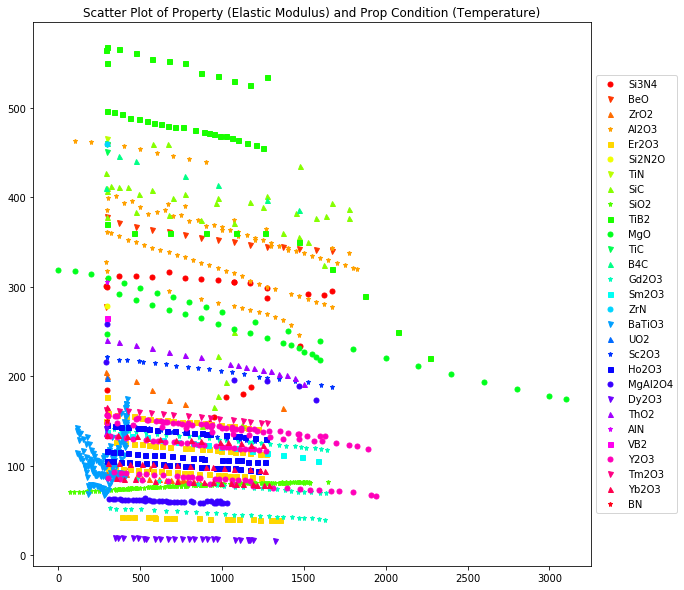

In [4]:
formulae= dat_t_copy.Formula.unique()
cfunc= plt.cm.get_cmap('hsv',len(formulae))
colors= [cfunc(i) for i in range(len(formulae))]
colors= dict(zip(formulae,colors))
symb= ['o','v','^','*','s']

#TODO: separate single crystal data and others
plt.figure(figsize= (10,10))
for i,item in enumerate(formulae):
    item_df= dat_t_copy[dat_t_copy.Formula==item]
    plt.plot(item_df['Temperature (K)'].values,np.array(item_df['Elastic Modulus (GPa)'],dtype= 'float'), 
             symb[i % len(symb)],color= colors[item],label= item, markersize= 5)
plt.title('Scatter Plot of Property (Elastic Modulus) and Prop Condition (Temperature)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.close()

Lets look at variation in the data set

In [5]:
dat_t_copy= dat_t.copy()
excluded= ['Formula','Crystallinity','composition','Reference','Elastic Modulus (GPa)']
dat_t_copy= dat_t_copy.drop(excluded,axis=1)
dat_t_copy= dat_t_copy.astype('float')
dat_des= dat_t_copy.describe()
dat_des= dat_des.astype('float')
dat_des

,Temperature (K),minimum Number,maximum Number,range Number,mean Number,avg_dev Number,mode Number,minimum MendeleevNumber,maximum MendeleevNumber,range MendeleevNumber,...,10-norm,transition metal fraction,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,frac s valence electrons,frac p valence electrons,frac d valence electrons,frac f valence electrons
count,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,...,1165.000000,1165.000000,1165.0,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000
mean,820.966524,7.703004,38.315021,30.612017,18.986953,13.643654,7.703004,43.524464,85.872103,42.347639,...,0.609940,0.037396,2.0,2.478390,0.184492,1.174077,0.374575,0.454005,0.038451,0.132970
std,447.075873,0.858172,23.909038,23.642175,9.258065,10.887440,0.858172,26.468235,3.482152,27.292142,...,0.040528,0.090924,0.0,0.540718,0.237815,1.962898,0.102361,0.137240,0.054067,0.217049
min,0.000000,4.000000,6.000000,1.000000,5.200000,0.320000,4.000000,9.000000,72.000000,1.000000,...,0.428730,0.000000,2.0,0.666667,0.000000,0.000000,0.200000,0.181818,0.000000,0.000000
25%,419.000000,8.000000,14.000000,6.000000,10.000000,2.666667,8.000000,12.000000,87.000000,14.000000,...,0.600002,0.000000,2.0,2.400000,0.000000,0.000000,0.263158,0.315789,0.000000,0.000000
50%,785.000000,8.000000,39.000000,31.000000,20.400000,14.880000,8.000000,37.000000,87.000000,50.000000,...,0.601032,0.000000,2.0,2.400000,0.000000,0.000000,0.416667,0.500000,0.000000,0.000000
75%,1140.000000,8.000000,64.000000,56.000000,30.400000,26.880000,8.000000,73.000000,87.000000,75.000000,...,0.601032,0.000000,2.0,2.666667,0.400000,2.800000,0.416667,0.562500,0.083333,0.368421
max,3100.000000,8.000000,92.000000,84.000000,36.000000,37.333333,8.000000,78.000000,87.000000,78.000000,...,0.800000,0.500000,2.0,3.333333,1.000000,5.600000,0.625000,0.625000,0.272727,0.560000


In [34]:
# there are nan values when I try to find the variation (std/mean) for the columns in the data set
std= np.array(dat_des.loc['std'],dtype= 'float')
mean= np.array(dat_des.loc['mean'],dtype= 'float')
variation= std/mean
dat_des.loc['variation']= variation

/Users/Prabudhya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In the above columns both mean and std deviation are zero.

## Linear Regressor 

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

In [32]:
excluded= ['Formula','Crystallinity','composition','Reference','Elastic Modulus (GPa)']
y= dat_t['Elastic Modulus (GPa)'].astype('float')
X= dat_t.drop(excluded,axis=1).astype('float')
X= X.drop(drop_cols,axis=1)

print('Number of descriptors: %i'%len(X.columns))
print('Number of data points: %i'%X.shape[0])

# split data set
X_learn= X[:800]
y_learn= y[:800]

X_test= X[800:]
y_test= y[800:]

lr= LinearRegression()

# Try fitting
lr.fit(X_learn,y_learn)

# get fit statistics
print('training R2 = ' + str(round(lr.score(X_learn, y_learn), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_test, y_pred=lr.predict(X_test))))

Number of descriptors: 135
Number of data points: 1165
training R2 = 0.904
training RMSE = 421.114


In [9]:
# Use 10-fold cross validation (90% training, 10% test)
crossvalidation = KFold(n_splits=10, shuffle=False, random_state=1)
scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=1)
rmse_scores = [np.sqrt(abs(s)) for s in scores]
r2_scores = cross_val_score(lr, X, y, scoring='r2', cv=crossvalidation, n_jobs=1)

print('Cross-validation results:')
print('Folds: %i, mean R2: %.3f' % (len(scores), np.mean(np.abs(r2_scores))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

Cross-validation results:
Folds: 10, mean R2: 2747258533394988544.000
Folds: 10, mean RMSE: 51833780700.692


In [10]:
from sklearn.model_selection import train_test_split
X['formula'] = dat_t['Formula']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
train_formula = X_train['formula']
X_train = X_train.drop('formula', axis=1)
test_formula = X_test['formula']
X_test = X_test.drop('formula', axis=1)

lr = LinearRegression()
lr.fit(X_train, y_train)

# get fit statistics
print('training R2 = ' + str(round(lr.score(X_train, y_train), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_train, y_pred=lr.predict(X_train))))
print('test R2 = ' + str(round(lr.score(X_test, y_test), 3)))
print('test RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_test, y_pred=lr.predict(X_test))))

training R2 = 0.898
training RMSE = 38.300
test R2 = 0.843
test RMSE = 45.725


## Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor

/Users/Prabudhya/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [12]:
excluded= ['Formula','Crystallinity','composition','Reference','Elastic Modulus (GPa)']
y= dat_t['Elastic Modulus (GPa)'].astype('float')
X= dat_t.drop(excluded,axis=1).astype('float')
X= X.drop(drop_cols,axis=1)

print('Number of descriptors: %i'%len(X.columns))
print('Number of data points: %i'%X.shape[0])

# split data set
X_learn= X[:800]
y_learn= y[:800]

X_test= X[800:]
y_test= y[800:]

rf = RandomForestRegressor(n_estimators=50, random_state=1)

rf.fit(X_learn, y_learn)

print('training R2 = ' + str(round(rf.score(X_learn, y_learn), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_test, y_pred=rf.predict(X_test))))

Number of descriptors: 135
Number of data points: 1165
training R2 = 0.981
training RMSE = 113.855


In [13]:
# compute cross validation scores for random forest model
r2_scores = cross_val_score(rf, X, y, scoring='r2', cv=crossvalidation, n_jobs=-1)
scores = cross_val_score(rf, X, y, scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=-1)
rmse_scores = [np.sqrt(abs(s)) for s in scores]

print('Cross-validation results:')
print('Folds: %i, mean R2: %.3f' % (len(scores), np.mean(np.abs(r2_scores))))
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))

Cross-validation results:
Folds: 10, mean R2: 0.708
Folds: 10, mean RMSE: 57.291


In [14]:
from sklearn.model_selection import train_test_split
X['formula'] = dat_t['Formula']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
train_formula = X_train['formula']
X_train = X_train.drop('formula', axis=1)
test_formula = X_test['formula']
X_test = X_test.drop('formula', axis=1)

rf_reg = RandomForestRegressor(n_estimators=50, random_state=1)
rf_reg.fit(X_train, y_train)

# get fit statistics
print('training R2 = ' + str(round(rf_reg.score(X_train, y_train), 3)))
print('training RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_train, y_pred=rf_reg.predict(X_train))))
print('test R2 = ' + str(round(rf_reg.score(X_test, y_test), 3)))
print('test RMSE = %.3f' % np.sqrt(mean_squared_error(y_true=y_test, y_pred=rf_reg.predict(X_test))))

training R2 = 0.98
training RMSE = 16.904
test R2 = 0.907
test RMSE = 35.180
